In [ ]:
!nvidia-smi

Wed Jul 19 16:42:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    30W /  70W |   7503MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install -qq transformers

In [ ]:
import transformers
import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertModel


import time
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette ='muted', font_scale = 1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import warnings
warnings.filterwarnings('ignore')


In [ ]:
!gdown --id 1aOELX_8sQCRb2f_wsJByTYlK_grgegc7
!gdown --id 19YsibsO56HJPAjrfdw4kHJeZ4UX6PFyW


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aOELX_8sQCRb2f_wsJByTYlK_grgegc7
To: /content/apps_info.csv
100% 28.0k/28.0k [00:00<00:00, 73.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19YsibsO56HJPAjrfdw4kHJeZ4UX6PFyW
To: /content/reviews.csv
100% 1.96M/1.96M [00:00<00:00, 167MB/s]


In [ ]:
df = pd.read_csv('reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,1752d5cc-e67c-40e7-bf38-cda11b5630e3,Nicky,https://play-lh.googleusercontent.com/a/AAcHTt...,I dont like the latest update. I've used the A...,1,111,23.01.03,2023-06-24 15:27:25,NaN,NaN,23.01.03,most_relevant,com.asda.android
1,832dd7f7-a914-4c02-ad42-b437bfc677d5,Archna Patel,https://play-lh.googleusercontent.com/a/AAcHTt...,"Sneaky asda, dont share offer ends dates, but ...",1,58,23.01.03,2023-05-07 06:19:28,NaN,NaN,23.01.03,most_relevant,com.asda.android
2,43a56d6c-9143-4bd7-a43f-7e82c64141e1,Ruth L2911,https://play-lh.googleusercontent.com/a/AAcHTt...,Worst App...EVER!! It freezes every single tim...,1,1,23.01.03,2023-05-23 00:01:14,NaN,NaN,23.01.03,most_relevant,com.asda.android
3,f10324c8-64ae-445c-b819-f7786b03f19d,scouseraph,https://play-lh.googleusercontent.com/a/AAcHTt...,I would love this app to include a feature whe...,1,1,23.01.03,2023-06-22 06:26:58,NaN,NaN,23.01.03,most_relevant,com.asda.android
4,2bed7537-026e-43b9-86d2-fc6150c757d4,Thorfinn,https://play-lh.googleusercontent.com/a-/AD_cM...,It's bloody awful. Sometimes the app freezes u...,1,0,23.01.03,2023-07-03 12:03:05,NaN,NaN,23.01.03,most_relevant,com.asda.android


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4632 entries, 0 to 4631
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              4632 non-null   object
 1   userName              4632 non-null   object
 2   userImage             4632 non-null   object
 3   content               4632 non-null   object
 4   score                 4632 non-null   int64 
 5   thumbsUpCount         4632 non-null   int64 
 6   reviewCreatedVersion  4336 non-null   object
 7   at                    4632 non-null   object
 8   replyContent          29 non-null     object
 9   repliedAt             29 non-null     object
 10  appVersion            4336 non-null   object
 11  sortOrder             4632 non-null   object
 12  appId                 4632 non-null   object
dtypes: int64(2), object(11)
memory usage: 470.6+ KB


In [ ]:
df['score'].value_counts()

3    1432
1     800
2     800
4     800
5     800
Name: score, dtype: int64

Text(0.5, 0, 'review score')

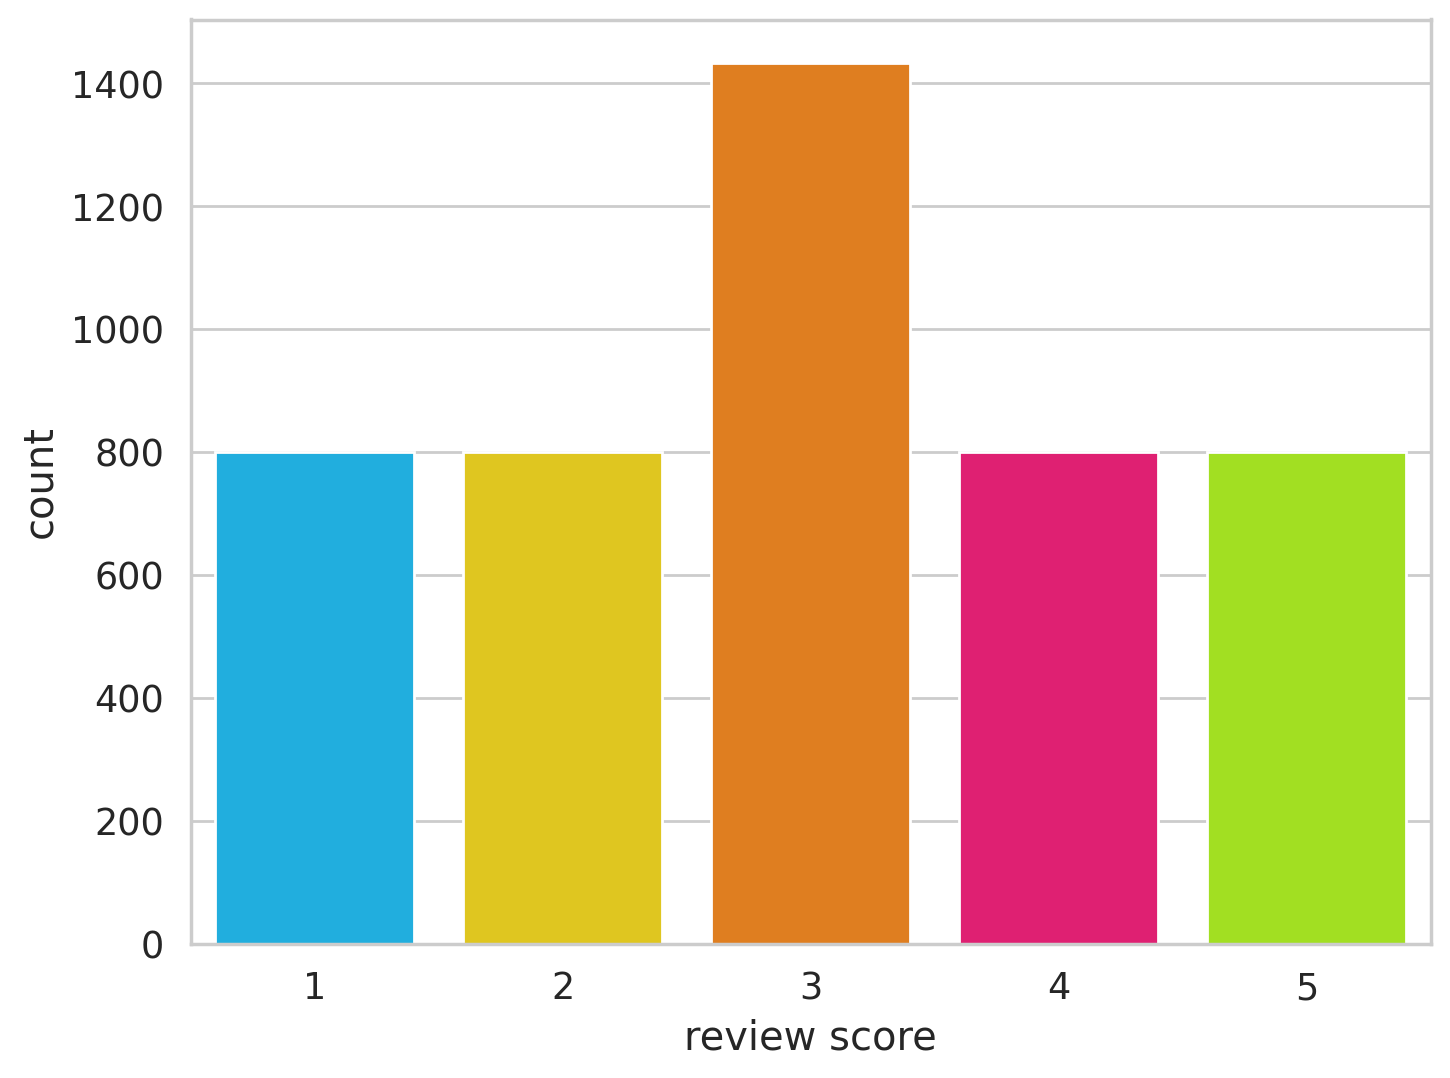

In [ ]:
sns.countplot(x = 'score', data=df)
plt.xlabel('review score')


In [ ]:
def to_sentiment(rating):
  rating = int(rating)

  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df['score'].apply(to_sentiment)    # create new feature

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

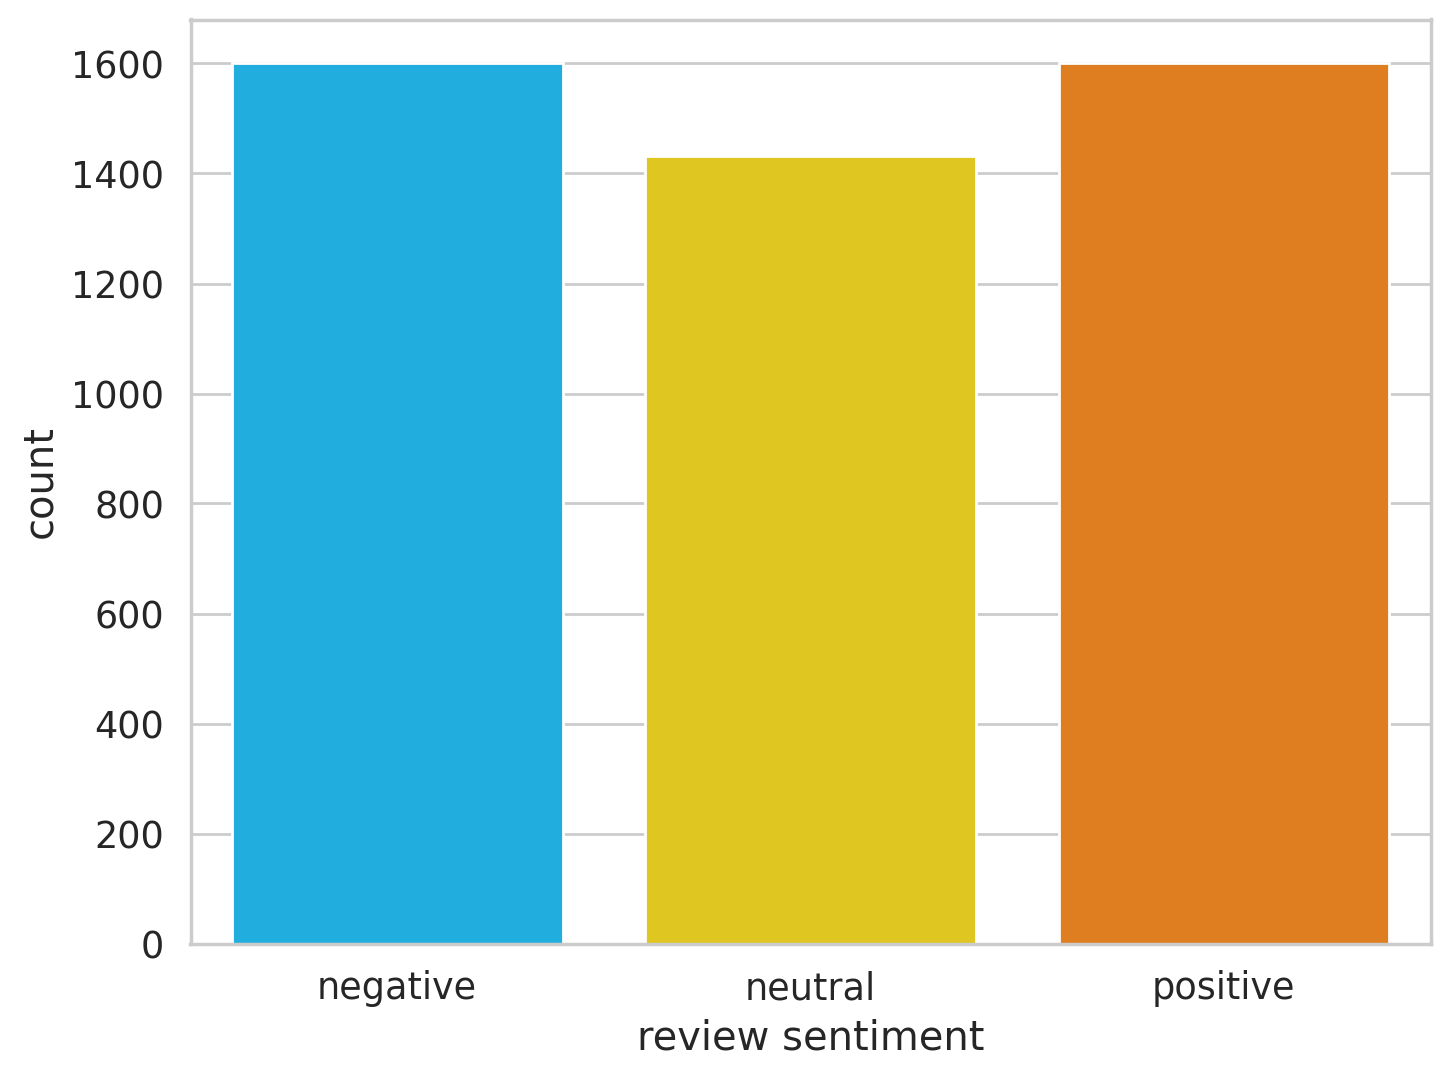

In [ ]:
class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(x= 'sentiment', data=df)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## DATA PREPROCESSING

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

In [ ]:
sample_text = 'my flight was delayed for 8 hours, i am very tired'

tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: my flight was delayed for 8 hours, i am very tired
   Tokens: ['my', 'flight', 'was', 'delayed', 'for', '8', 'hours', ',', 'i', 'am', 'very', 'tired']
Token IDs: [1139, 3043, 1108, 8088, 1111, 129, 2005, 117, 178, 1821, 1304, 4871]


### Special Tokens

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

print(encoding['input_ids'])

tensor([[ 101, 1139, 3043, 1108, 8088, 1111,  129, 2005,  117,  178, 1821, 1304,
         4871,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:

In [ ]:
token_lens = []

for txt in df['content']:
  tokens = tokenizer.encode(txt, max_length = 512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


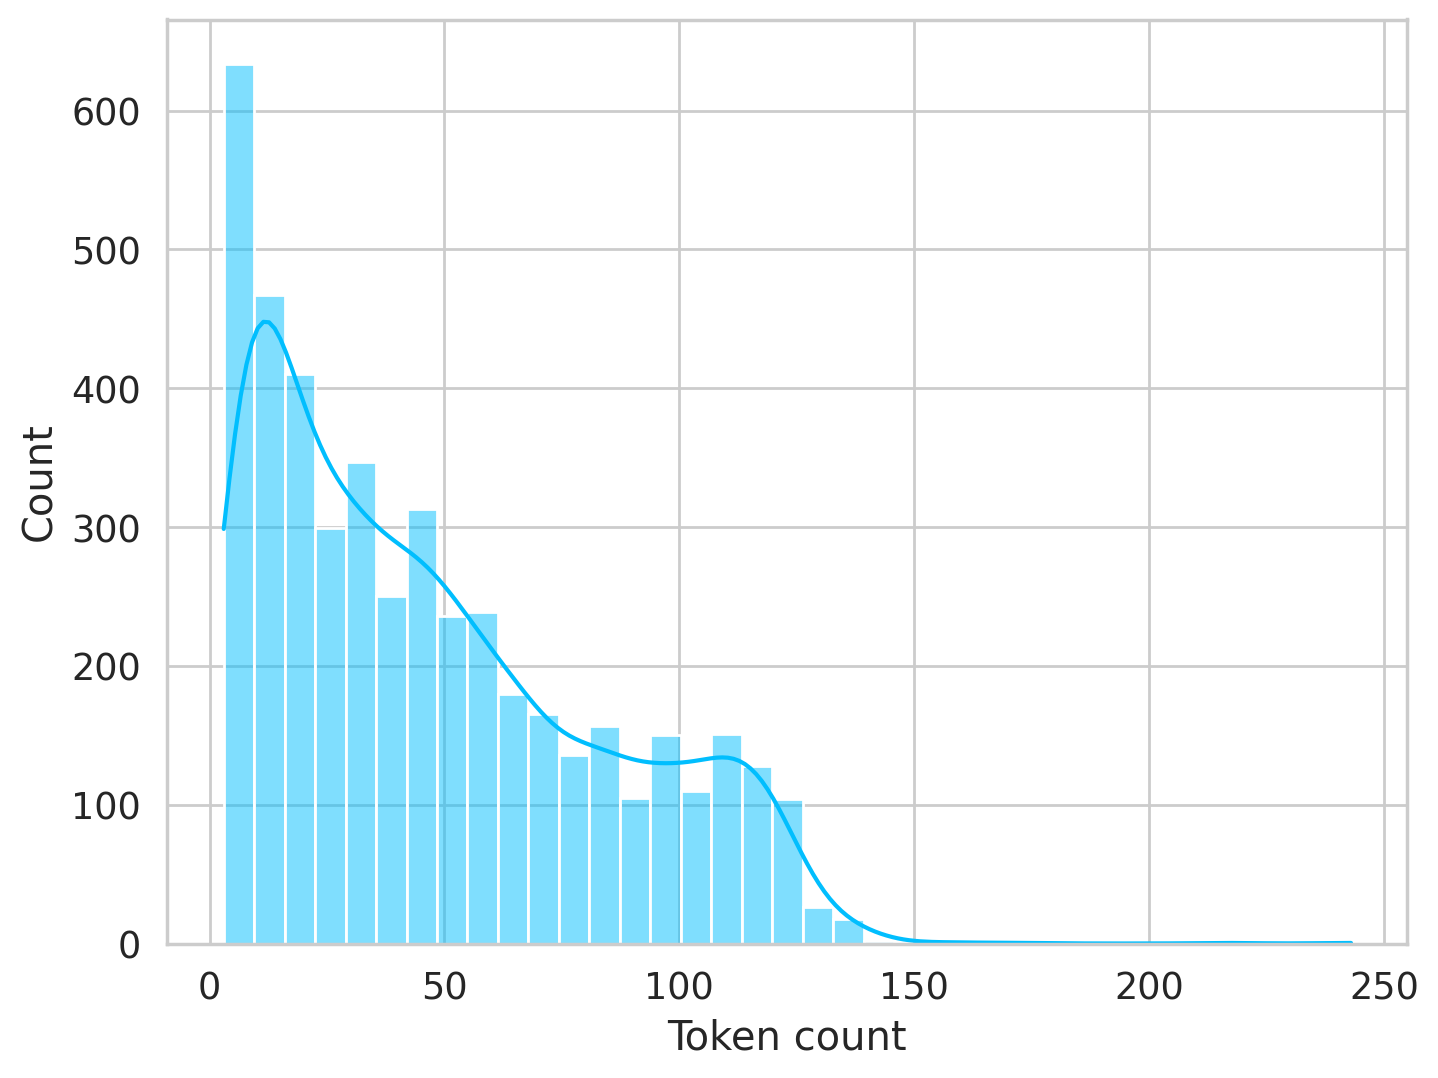

In [ ]:
sns.histplot(token_lens, kde=True)
plt.xlabel('Token count')
plt.show()

In [ ]:

class GPReviewDataset(data.Dataset):

  def __init__(self, review, targets, tokenizer, max_len):
    self.review = review
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      max_length=self.max_len,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
MAX_LEN = 150
BATCH_SIZE = 12
EPOCHS = 20


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

df_train.shape, df_val.shape, df_test.shape

((3705, 14), (463, 14), (464, 14))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df['content'].to_numpy(),
      targets = df['sentiment'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return data.DataLoader(
      ds,
      batch_size = batch_size,
      num_workers =2
  )


In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([12, 150])
torch.Size([12, 150])
torch.Size([12])


And try to use it on the encoding of our sample text:

In [ ]:
outputs = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output


In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape


torch.Size([1, 768])

## sentiment classifer

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__ (self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
batch_data = next(iter(train_data_loader))
input_ids = batch_data['input_ids'].to(device)
attention_mask = batch_data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([12, 150])
torch.Size([12, 150])


In [ ]:
print(type(batch_data['input_ids']))
print(type(batch_data['attention_mask']))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
import torch.nn.functional as F

output = model(input_ids, attention_mask)
probabilities = F.softmax(output, dim=1)
probabilities


tensor([[0.2449, 0.3796, 0.3755],
        [0.2422, 0.2995, 0.4582],
        [0.3164, 0.2767, 0.4069],
        [0.2540, 0.3106, 0.4354],
        [0.5786, 0.1994, 0.2220],
        [0.2166, 0.4471, 0.3363],
        [0.2719, 0.3220, 0.4061],
        [0.3760, 0.2061, 0.4179],
        [0.3829, 0.1898, 0.4273],
        [0.3296, 0.2062, 0.4642],
        [0.3394, 0.1892, 0.4713],
        [0.3729, 0.1902, 0.4368]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader)* EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):


  model = model.train()
  losses=[]
  correct_predictions = 0


  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()


  return correct_predictions.double()/n_examples, np.mean(losses)



In [ ]:
def eval_model(model,data_loader,loss_fn,device,n_examples):


  model = model.eval()
  losses=[]
  correct_predictions = 0

  with torch.no_grad():



    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids, attention_mask=attention_mask)

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())



  return correct_predictions.double()/n_examples, np.mean(losses)

In [ ]:
from sqlalchemy.util import defaultdict
start_time = time.time()

history = defaultdict(list)

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-'*10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )

  print(f'Trian loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

Epoch 1/20
----------
Trian loss 0.8581383032513282 accuracy 0.5802968960863697
Val loss 0.629505951435138 accuracy 0.7213822894168467

Epoch 2/20
----------
Trian loss 0.5504307970886864 accuracy 0.7716599190283401
Val loss 0.6335048843652774 accuracy 0.7602591792656588

Epoch 3/20
----------
Trian loss 0.32491720287870723 accuracy 0.8796221322537111
Val loss 0.8244563616239108 accuracy 0.7451403887688985

Epoch 4/20
----------
Trian loss 0.19066615989974256 accuracy 0.9425101214574898
Val loss 1.1385284572696457 accuracy 0.7710583153347733

Epoch 5/20
----------
Trian loss 0.16354109195413666 accuracy 0.9503373819163292
Val loss 1.2928661663646404 accuracy 0.7645788336933046

Epoch 6/20
----------
Trian loss 0.0883772582286467 accuracy 0.9743589743589743
Val loss 1.385357844332854 accuracy 0.7537796976241901

Epoch 7/20
----------
Trian loss 0.060556823506417855 accuracy 0.9843454790823212
Val loss 1.4445348603603168 accuracy 0.7732181425485961

Epoch 8/20
----------
Trian loss 0.047

(0.0, 1.0)

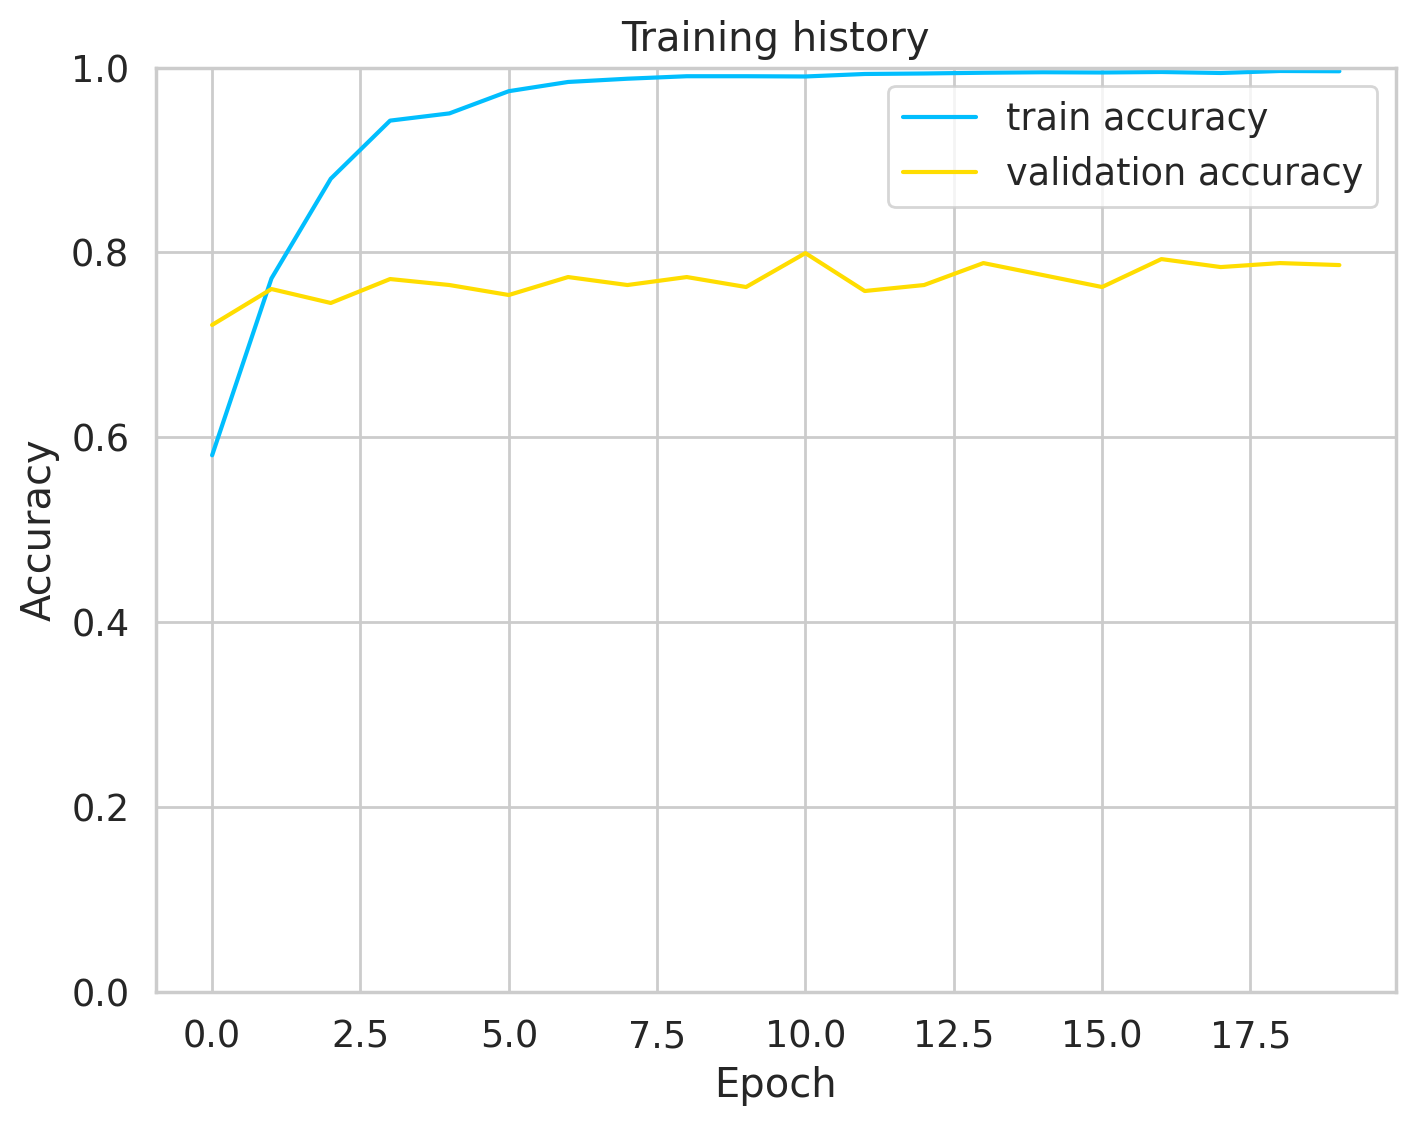

In [ ]:
train_acc = [t.cpu().numpy() for t in history['train_acc']]
val_acc = [t.cpu().numpy() for t in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/best_model_state.bin'))
model = model.to(device)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions =[]
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values


In [ ]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print("test_acc : ", test_acc)
print("test_loss : ", test_loss)


test_acc :  tensor(0.8039, device='cuda:0', dtype=torch.float64)
test_loss :  1.7253444334432386


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.85      0.72      0.78       151
     neutral       0.69      0.78      0.73       144
    positive       0.88      0.89      0.89       169

    accuracy                           0.80       464
   macro avg       0.81      0.80      0.80       464
weighted avg       0.81      0.80      0.80       464



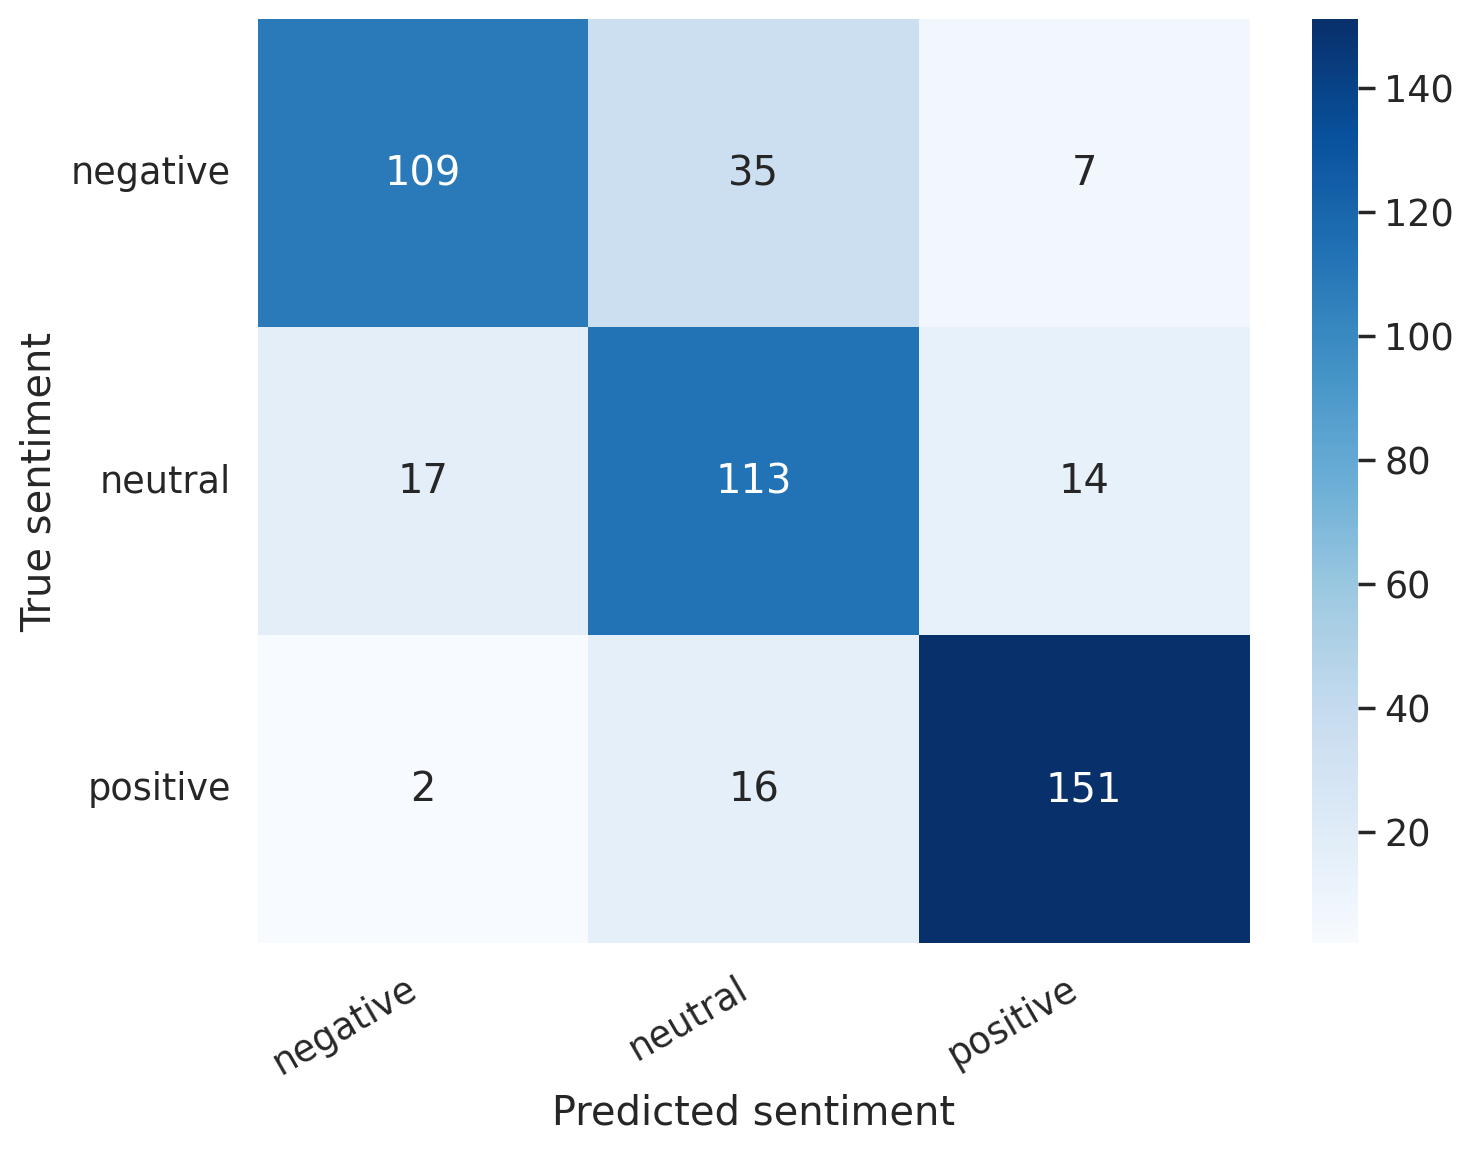

In [ ]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Great ap. Takes the stress out of the weekly shop. Helps because you
can add to list thru the week as things run out.

True sentiment: positive


(0.0, 1.0)

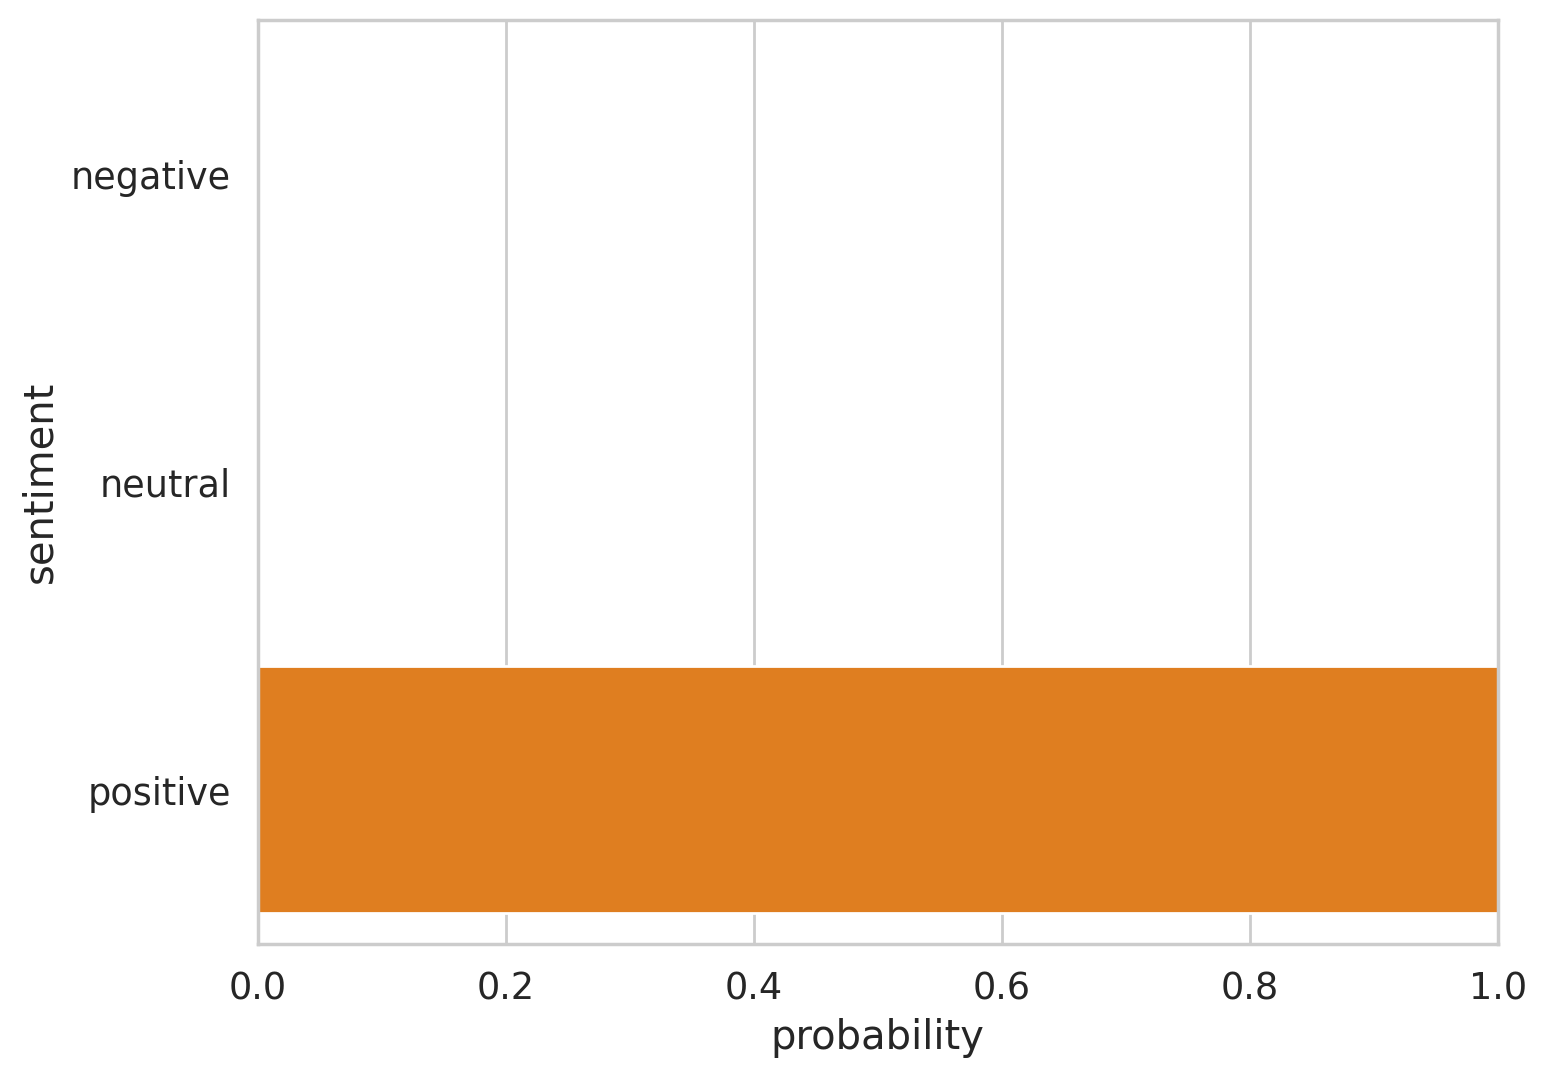

In [ ]:
from textwrap import wrap
idx = 69
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')


#Now we can look at the confidence of each sentiment of our model:

sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])

Great, easy app that saves money. love the recipe feature.

True sentiment: positive
Predicted sentiment: positive


(0.0, 1.0)

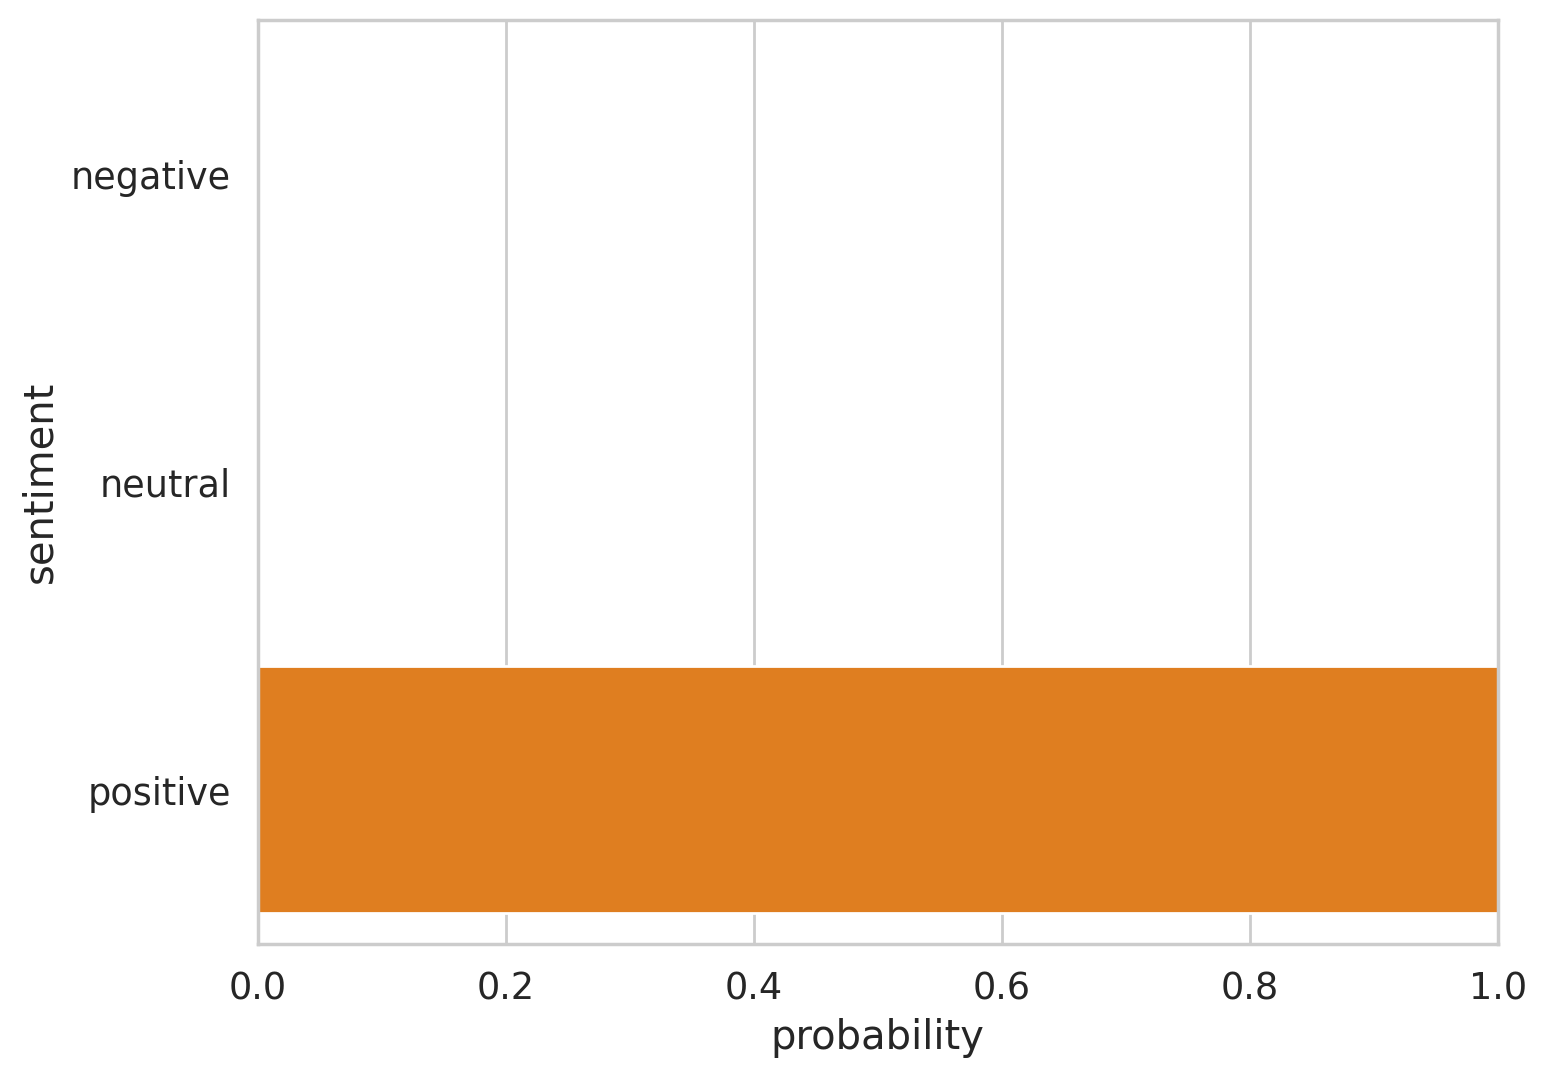

In [ ]:
from textwrap import wrap

idx = 36
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_sentiment = y_pred[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
print(f'Predicted sentiment: {class_names[pred_sentiment]}')

# Now we can look at the confidence of each sentiment of our model:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1])


Predicting on Raw Text

In [ ]:
review_text = "Yesterday at 2:30 pm I entered the Ellesmere port store with my service dog in which I have been going in with her for some time now.. I was shouted at by a security guard who was at the door who kept asking me to prove what was wrong with me and told me to leave however my service dog was in full working gear I spoke to the gentleman who was very rude and kept putting me down. He then told another staff member to get the manager.. the manager was very friendly and could see I was distressed to the point I was literally shaking.. I have never had an issue taking my service dog in before but this security guard was so rude and made me feel so small I felt like crying.. she is with me for a reason and now I feel I can no longer shop in asda due to this man"


encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)


print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Yesterday at 2:30 pm I entered the Ellesmere port store with my service dog in which I have been going in with her for some time now.. I was shouted at by a security guard who was at the door who kept asking me to prove what was wrong with me and told me to leave however my service dog was in full working gear I spoke to the gentleman who was very rude and kept putting me down. He then told another staff member to get the manager.. the manager was very friendly and could see I was distressed to the point I was literally shaking.. I have never had an issue taking my service dog in before but this security guard was so rude and made me feel so small I felt like crying.. she is with me for a reason and now I feel I can no longer shop in asda due to this man
Sentiment  : negative


# Hyperparameter

In [ ]:
"""
from torch.utils.data import DataLoader

def create_data_loader2(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df['content'].to_numpy(),
      targets = df['sentiment'].to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers =2
  )"""


"\nfrom torch.utils.data import DataLoader\n\ndef create_data_loader2(df, tokenizer, max_len, batch_size):\n  ds = GPReviewDataset(\n      review = df['content'].to_numpy(),\n      targets = df['sentiment'].to_numpy(),\n      tokenizer = tokenizer,\n      max_len = max_len\n  )\n\n  return DataLoader(\n      ds,\n      batch_size = batch_size,\n      num_workers =2\n  )"

In [ ]:
"""

from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform


# Define the hyperparameters to tune and their ranges
param_grid = {
    'lr': uniform(1e-5, 1e-4),
    'batch_size': [8, 16, 32, 64],
    'epochs': [5, 10, 15, 20],
    'dropout': uniform(0.1, 0.5),
}

# Define the number of iterations for Random Search
n_iter_search = 20

# Create a random parameter sampler
param_list = list(ParameterSampler(param_grid, n_iter=n_iter_search))

# Loop over the sampled parameters
for params in param_list:
    # Set the parameters
    lr = params['lr']
    batch_size = params['batch_size']
    epochs = params['epochs']
    dropout = params['dropout']

    # Create a new instance of the model with the current parameters
    model = SentimentClassifier(n_classes=3)
    model.bert.config.hidden_dropout_prob = dropout
    model = model.to(device)

    # Create a new optimizer with the current learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Create new data loaders with the current batch size
    train_data_loader2 = create_data_loader2(df_train, tokenizer, MAX_LEN, batch_size)
    val_data_loader2 = create_data_loader2(df_val, tokenizer, MAX_LEN, batch_size)
    test_data_loader2 = create_data_loader2(df_test, tokenizer, MAX_LEN, batch_size)

    # Train and evaluate the model with the current parameters
    for epoch in range(epochs):
        train_acc, train_loss = train_epoch(
            model,
            train_data_loader2,
            loss_fn,
            optimizer,
            device,
            scheduler,
            len(df_train)
        )

        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            val_data_loader2,
            loss_fn,
            device,
            scheduler,
            len(df_val)
        )

        print(f'Val loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state_RSCV.bin')
            best_accuracy = val_acc """


"\n\nfrom sklearn.model_selection import ParameterSampler\nfrom scipy.stats import uniform\n\n\n# Define the hyperparameters to tune and their ranges\nparam_grid = {\n    'lr': uniform(1e-5, 1e-4),\n    'batch_size': [8, 16, 32, 64],\n    'epochs': [5, 10, 15, 20],\n    'dropout': uniform(0.1, 0.5),\n}\n\n# Define the number of iterations for Random Search\nn_iter_search = 20\n\n# Create a random parameter sampler\nparam_list = list(ParameterSampler(param_grid, n_iter=n_iter_search))\n\n# Loop over the sampled parameters\nfor params in param_list:\n    # Set the parameters\n    lr = params['lr']\n    batch_size = params['batch_size']\n    epochs = params['epochs']\n    dropout = params['dropout']\n\n    # Create a new instance of the model with the current parameters\n    model = SentimentClassifier(n_classes=3)\n    model.bert.config.hidden_dropout_prob = dropout\n    model = model.to(device)\n\n    # Create a new optimizer with the current learning rate\n    optimizer = torch.optim.A